In [1]:
import datetime
import time
import pickle
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import os
from Main import settings, features, pf_set
import time
import pickle
from pandas.tseries.offsets import DateOffset
import Prepare_Data
import data_run_files
import return_prediction_functions
from return_prediction_functions import rff
import numpy as np
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import Ridge
import re
import matplotlib.pyplot as plt
import seaborn as sns


start_date = pd.to_datetime('1952-12-31')
end_date = pd.to_datetime('2022-12-31')




Features list length: 154


In [5]:
# Definér folder_name, så alle paths kan ændres ét sted
folder_name = "mega_"


file_path_usa_dsf = os.path.join(".", folder_name, "usa_dsf.parquet")
file_path_usa = os.path.join(".", folder_name, "usa_rvol.parquet")
file_path_id_test = os.path.join(".", folder_name, "top_5_percent_ids.csv")
file_path_market_returns = os.path.join(".", folder_name, "market_returns_test.csv")
output_path_usa_dsf = os.path.join(".", folder_name, "usa_dsf_test.parquet")
output_path_usa = os.path.join(".", folder_name, "usa_test.parquet")
output_path_market_returns = os.path.join(folder_name, "market_returns_test.csv")
file_path_world_ret = os.path.join(".", folder_name, "world_ret_test.csv")
output_path = os.path.join(".", folder_name, "")  

file_path_usa_test = os.path.join(".", folder_name, "usa_test.parquet")
daily_file_path = os.path.join(".", folder_name, "usa_dsf_test.parquet")
risk_free_path = os.path.join(".", folder_name, "risk_free_test.csv")
market_path = os.path.join(".", folder_name, "market_returns_test.csv")

# Definér datoer
start_date = pd.to_datetime('1952-12-31')
end_date = pd.to_datetime('2022-12-31')

# Processering af risk_free med data_run_files
risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date, output_path = risk_free_path)

# Udregning af wealth
wealth_end = pf_set["wealth"]
end = settings["split"]["test_end"]
market_test = Prepare_Data.load_and_filter_market_returns_test(market_path)
wealth = Prepare_Data.wealth_func(wealth_end, end, market_test, risk_free)

h_list = [1]  # Horisonter

Filtrering udført. Antal rækker efter filtrering: 841
Fil gemt som .\last_try_data\risk_free_test.csv
Filen er indlæst og filtreret succesfuldt.


In [11]:
# billede outputfolder
output_folder = r"C:\Users\andre\Documents\4. semester Kandidatspeciale\Billeder direkte fra koden"
input_path_chars_behandlet = os.path.join(".", folder_name, "chars_behandlet.parquet")
chars = pd.read_parquet(input_path_chars_behandlet)

In [12]:
def add_return_predictions_arima(chars, settings, get_from_path_model):

    for h in range(1, 2): #Hardcoded 2 ind for vi har kun 1 horizon
        file_path = os.path.join(get_from_path_model, f"model_{h}_arima_pred.pkl")
        with open(file_path, 'rb') as f:
            model_dict = pickle.load(f)

        all_preds = []
        for date_key, subdict in model_dict.items():
            # Antag at hver subdictionary indeholder en key "pred"
            pred_df = pd.DataFrame(subdict['pred'])
            all_preds.append(pred_df)

        # Saml alle forudsigelsesdata
        pred_df_all = pd.concat(all_preds, ignore_index=True)
        pred_df_all = pred_df_all[['id', 'eom', 'pred']].rename(columns={'pred': f'pred_ld{h}'})

        # Merge forudsigelserne ind i chars
        chars = chars[chars["valid"] == True]
        chars = chars.merge(pred_df_all, on=['id', 'eom'], how='left')

    return chars
chars_no_constant_demeaned = add_return_predictions_arima(chars, settings, output_path)

FileNotFoundError: [Errno 2] No such file or directory: '.\\last_try_data\\model_1_arima_pred.pkl'

In [ ]:
chars_no_constant_demeaned = add_return_predictions_arima(chars, settings, output_path)

In [7]:
def long_horizon_ret(data, h, impute):
    # Udvælg unikke datoer for observationer med ikke-missing ret_exc
    # Vi beholder kun én kolonne, og kalder den 'merge_date'
    dates = data.loc[data['ret_exc'].notna(), ['eom']].drop_duplicates().rename(columns={'eom': 'merge_date'})
    
    # Beregn start- og slutdato for hver id (kun for de observationer, hvor ret_exc ikke er missing)
    ids = data.loc[data['ret_exc'].notna()].groupby('id').agg(start=('eom', 'min'),
                                                               end=('eom', 'max')).reset_index()
    
    # Udfør en cross join mellem ids og dates
    full_ret = ids.merge(dates, how='cross')
    
    # Filtrer, så kun de rækker bevares, hvor merge_date ligger mellem start og end
    full_ret = full_ret[(full_ret['merge_date'] >= full_ret['start']) & (full_ret['merge_date'] <= full_ret['end'])]
    
    # Drop start- og end-kolonnerne, og omdøb merge_date til eom
    full_ret = full_ret.drop(columns=['start', 'end']).rename(columns={'merge_date': 'eom'})
    
    # Merge med de originale data for at få ret_exc
    full_ret = full_ret.merge(data[['id', 'eom', 'ret_exc']], on=['id', 'eom'], how='left')
    
    # Sortér efter id og eom
    full_ret = full_ret.sort_values(['id', 'eom']).reset_index(drop=True)
    
    # Opret kolonner for long horizon returns: ret_ld1, ret_ld2, ..., ret_ld{h}
    for l in range(1, h + 1):
        full_ret[f'ret_ld{l}'] = full_ret.groupby('id')['ret_exc'].shift(-l)
    
    # Fjern den oprindelige ret_exc-kolonne
    full_ret.drop(columns=['ret_exc'], inplace=True)
    
    # Fjern rækker, hvor alle ret_ld-kolonner er missing
    lag_cols = [f'ret_ld{l}' for l in range(1, h + 1)]
    all_missing = full_ret[lag_cols].isna().all(axis=1)
    print(f"All missing excludes {all_missing.mean() * 100:.2f}% of the observations")
    full_ret = full_ret[~all_missing].reset_index(drop=True)
    
    # Imputering af manglende værdier
    if impute == "zero":
        full_ret[lag_cols] = full_ret[lag_cols].fillna(0)
    elif impute == "mean":
        # Imputer pr. eom
        full_ret[lag_cols] = full_ret.groupby('eom')[lag_cols].transform(lambda x: x.fillna(x.mean()))
    elif impute == "median":
        full_ret[lag_cols] = full_ret.groupby('eom')[lag_cols].transform(lambda x: x.fillna(x.median()))
    
    return full_ret


## Skab data_ret_ld1

In [8]:

world_ret = pd.read_csv(file_path_world_ret, usecols=["excntry", "id", "eom", "ret_exc"], dtype={"eom": str})
filtered_world_ret = world_ret[(world_ret["excntry"] == "USA") & (world_ret["id"] <= 99999)].copy()
filtered_world_ret["eom"] = pd.to_datetime(filtered_world_ret["eom"])
monthly = filtered_world_ret
data_ret = long_horizon_ret(filtered_world_ret, h=12, impute="zero")
data_ret_ld1 = data_ret.copy()
data_ret_ld1['eom_ret'] = (data_ret_ld1['eom'] + pd.DateOffset(months=1)) + MonthEnd(0)
data_ret_ld1 = data_ret_ld1[['id', 'eom', 'eom_ret', 'ret_ld1']]
data_ret_ld1 = data_ret_ld1.merge(risk_free, on='eom', how='left')
data_ret_ld1['tr_ld1'] = data_ret_ld1['ret_ld1'] + data_ret_ld1['rf']
data_ret_ld1.drop(columns=['rf'], inplace=True)
temp = data_ret_ld1[['id', 'eom', 'tr_ld1']].copy()

temp['eom'] = temp['eom'] + pd.offsets.MonthEnd(1)

temp = temp.rename(columns={'tr_ld1': 'tr_ld0'})

data_ret_ld1 = data_ret_ld1.merge(temp, on=['id', 'eom'], how='left')
data_ret_ld1

All missing excludes 0.53% of the observations


,id,eom,eom_ret,ret_ld1,tr_ld1,tr_ld0
0,10078,1986-04-30,1986-05-31,0.107035,0.112235,NaN
1,10078,1986-05-31,1986-06-30,-0.123302,-0.118402,0.112235
2,10078,1986-06-30,1986-07-31,-0.044381,-0.039181,-0.118402
3,10078,1986-07-31,1986-08-31,-0.078384,-0.073184,-0.039181
4,10078,1986-08-31,1986-09-30,-0.013633,-0.009033,-0.073184
...,...,...,...,...,...,...
127132,93436,2022-07-31,2022-08-31,-0.074390,-0.073590,0.323553
127133,93436,2022-08-31,2022-09-30,-0.039518,-0.037618,-0.073590
127134,93436,2022-09-30,2022-10-31,-0.144495,-0.142595,-0.037618
127135,93436,2022-10-31,2022-11-30,-0.147182,-0.144882,-0.142595


## chars

In [9]:
from Prepare_Data import process_risk_free_rate, process_return_data, wealth_func, load_and_filter_market_returns_test, process_all_data, process_cluster_labels


In [10]:
chars, daily = process_all_data(
    file_path_usa_test, daily_file_path, file_path_world_ret, risk_free_path, market_path
)

All missing excludes 0.53% of the observations


KeyError: "['start', 'end', 'merge_date'] not found in axis"

In [5]:
chars = pd.read_parquet(output_path_usa)
print("Dimensioner for fulde data:")
print(chars.shape)

# ---------------------------------------------------------
# 2. Definér de kolonner, der skal hentes (unik liste)
# Her antages, at 'features' er en liste med ekstra kolonnenavne
selected_cols = list(set(["id", "eom", "sic", "size_grp", "me", "rvol_252d", "dolvol_126d"] + features))
# Læs kun de nødvendige kolonner fra Parquet-filen
chars = pd.read_parquet(output_path_usa, columns=selected_cols)

chars = chars[chars['id'] <= 99999]
chars['eom'] = pd.to_datetime(chars['eom'])

print("Dimensioner efter valg af kolonner:")

print(chars.shape)

chars['dolvol'] = chars['dolvol_126d']
# b) 'lambda' beregnes som 2/dolvol * settings['pi']
chars['lambda'] = 2 / chars['dolvol'] * settings['pi']
# c) 'rvol_m' beregnes som rvol_252d * sqrt(21)
chars['rvol_m'] = chars['rvol_252d'] * np.sqrt(21)

chars = pd.merge(chars, data_ret_ld1, on=['id', 'eom'], how='left')


temp = wealth.copy()
# Flyt eom til den sidste dag i næste måned:
temp['eom'] = temp['eom'] + pd.offsets.MonthEnd(1)
# Omdøb 'mu_ld1' til 'mu_ld0'
temp = temp.rename(columns={'mu_ld1': 'mu_ld0'})
# Merge wealth-data med chars på kolonnen eom
chars = pd.merge(chars, temp[['eom', 'mu_ld0']], on='eom', how='left')
print("Data efter merge med data_ret_ld1:")
print(chars.shape)

# Date screen: Udregn andelen af rækker, hvor eom ligger uden for screens-intervallet
date_excludes = ((chars['eom'] < settings['screens']['start']) | (chars['eom'] > settings['screens']['end'])).mean() * 100
print(f"   Date screen excludes {date_excludes:.2f}% of the observations")

# Filtrer data, så kun rækker med eom inden for intervallet beholdes
chars = chars[(chars['eom'] >= settings['screens']['start']) & (chars['eom'] <= settings['screens']['end'])]
print("Dim after date screen:", chars.shape)

# Monitor screen impact
n_start = chars.shape[0]
me_start = chars['me'].sum(skipna=True)

# Require non-missing me
me_missing_pct = chars['me'].isna().mean() * 100
print(f"   Non-missing me excludes {me_missing_pct:.2f}% of the observations")
chars = chars[~chars['me'].isna()]

# Require non-missing return for t og t+1: (tr_ld1 og tr_ld0)
valid_return_excludes = ((chars['tr_ld1'].isna()) | (chars['tr_ld0'].isna())).mean() * 100
print(f"   Valid return req excludes {valid_return_excludes:.2f}% of the observations")
chars = chars[chars['tr_ld0'].notna() & chars['tr_ld1'].notna()]

print("Final dim:", chars.shape)


ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

In [39]:
dolvol_excludes = ((chars['dolvol'].isna()) | (chars['dolvol'] == 0)).mean() * 100
print(f"   Non-missing/non-zero dolvol excludes {dolvol_excludes:.2f}% of the observations")

# Filtrer rækker, hvor 'dolvol' ikke er missing og > 0
chars = chars[(~chars['dolvol'].isna()) & (chars['dolvol'] > 0)]

# --- Require valid SIC code ---
# Beregn andelen af observationer med en tom SIC (""), svarende til R's mean(chars$sic=="")
sic_excludes = (chars['sic'] == "").mean() * 100
print(f"   Valid SIC code excludes {sic_excludes:.2f}% of the observations")

# Filtrer rækker, hvor 'sic' ikke er missing
chars = chars[~chars['sic'].isna()]

# --- Feature screens ---
# For hver række beregnes antallet af ikke-missing feature-værdier (for de kolonner, der er defineret i 'features')
feat_available = chars[features].notna().sum(axis=1)

# Minimum antal features, som kræves: floor(antal features * settings['screens']['feat_pct'])
min_feat = int(np.floor(len(features) * settings['screens']['feat_pct']))

# Udregn procentdelen af observationer, hvor antallet af tilgængelige features er mindre end min_feat
feat_excludes = (feat_available < min_feat).mean() * 100
print(f"   At least {settings['screens']['feat_pct']*100:.0f}% of feature excludes {feat_excludes:.2f}% of the observations")

# Filtrer rækker, hvor antallet af tilgængelige features er >= min_feat
chars = chars[feat_available >= min_feat]
print("Final dimensions after feature screen:", chars.shape)

   Non-missing/non-zero dolvol excludes 0.03% of the observations
   Valid SIC code excludes 0.03% of the observations
   At least 50% of feature excludes 0.00% of the observations
Final dimensions after feature screen: (125158, 128)


In [40]:
final_obs_pct = (len(chars) / n_start) * 100
final_me_pct = (chars['me'].sum() / me_start) * 100
print(f"   In total, the final dataset has {final_obs_pct:.2f}% of the observations and {final_me_pct:.2f}% of the market cap in the post {settings['screens']['start']} data")
run_sub = False
if run_sub:
    np.random.seed(settings['seed'])
    unique_ids = chars['id'].unique()
    sample_ids = np.random.choice(unique_ids, size=2500, replace=False)
    chars = chars[chars['id'].isin(sample_ids)]
if settings['feat_prank']:
    # Konverter feature-kolonner til float (dobbelt præcision)
    chars[features] = chars[features].astype(float)
    
    def ecdf_transform(s):
        return s.rank(method='average', pct=True)
    
    for i, f in enumerate(features):
        if (i + 1) % 10 == 0:
            print(f"Feature {i+1} out of {len(features)}")
        
        # Gem en lokal variabel med indikator for nøjagtige nuller
        zero = (chars[f] == 0)
        
        # Udfør ECDF-transformation per gruppe defineret af 'eom'
        chars[f] = chars.groupby('eom')[f].transform(lambda s: ecdf_transform(s))
        
        # Sæt de oprindelige 0-værdier tilbage til 0
        chars.loc[zero, f] = 0


   In total, the final dataset has 99.73% of the observations and 99.37% of the market cap in the post 1982-12-31 00:00:00 data
Feature 10 out of 115
Feature 20 out of 115
Feature 30 out of 115
Feature 40 out of 115
Feature 50 out of 115
Feature 60 out of 115
Feature 70 out of 115
Feature 80 out of 115
Feature 90 out of 115
Feature 100 out of 115
Feature 110 out of 115


In [41]:
if settings['feat_impute']:
    if settings['feat_prank']:
        # For hvert feature: hvis manglende, sæt til 0.5
        for f in features:
            chars[f] = chars[f].fillna(0.5)
    else:
        # For hvert feature: imputér manglende værdier med median inden for hver eom-gruppe
        for f in features:
            chars[f] = chars.groupby('eom')[f].transform(lambda s: s.fillna(s.median()))


In [42]:
# Konverter sic til numerisk (fejl konverteres til NaN)
chars['sic'] = pd.to_numeric(chars['sic'], errors='coerce')


cond_no_dur = (
    chars['sic'].between(100, 999) |
    chars['sic'].between(2000, 2399) |
    chars['sic'].between(2700, 2749) |
    chars['sic'].between(2770, 2799) |
    chars['sic'].between(3100, 3199) |
    chars['sic'].between(3940, 3989)
)

cond_durbl = (
    chars['sic'].between(2500, 2519) |
    chars['sic'].between(3630, 3659) |
    chars['sic'].isin([3710, 3711, 3714, 3716]) |
    chars['sic'].between(3750, 3751) |
    (chars['sic'] == 3792) |
    chars['sic'].between(3900, 3939) |
    chars['sic'].between(3990, 3999)
)

cond_manuf = (
    chars['sic'].between(2520, 2589) |
    chars['sic'].between(2600, 2699) |
    chars['sic'].between(2750, 2769) |
    chars['sic'].between(3000, 3099) |
    chars['sic'].between(3200, 3569) |
    chars['sic'].between(3580, 3629) |
    chars['sic'].between(3700, 3709) |
    chars['sic'].between(3712, 3713) |
    (chars['sic'] == 3715) |
    chars['sic'].between(3717, 3749) |
    chars['sic'].between(3752, 3791) |
    chars['sic'].between(3793, 3799) |
    chars['sic'].between(3830, 3839) |
    chars['sic'].between(3860, 3899)
)

cond_enrgy = (
    chars['sic'].between(1200, 1399) |
    chars['sic'].between(2900, 2999)
)

cond_chems = (
    chars['sic'].between(2800, 2829) |
    chars['sic'].between(2840, 2899)
)

cond_buseq = (
    chars['sic'].between(3570, 3579) |
    chars['sic'].between(3660, 3692) |
    chars['sic'].between(3694, 3699) |
    chars['sic'].between(3810, 3829) |
    chars['sic'].between(7370, 7379)
)

cond_telcm = chars['sic'].between(4800, 4899)
cond_utils = chars['sic'].between(4900, 4949)

cond_shops = (
    chars['sic'].between(5000, 5999) |
    chars['sic'].between(7200, 7299) |
    chars['sic'].between(7600, 7699)
)

cond_hlth = (
    chars['sic'].between(2830, 2839) |
    (chars['sic'] == 3693) |
    chars['sic'].between(3840, 3859) |
    chars['sic'].between(8000, 8099)
)

cond_money = chars['sic'].between(6000, 6999)

# Saml betingelser og tilhørende valg
conditions = [
    cond_no_dur,
    cond_durbl,
    cond_manuf,
    cond_enrgy,
    cond_chems,
    cond_buseq,
    cond_telcm,
    cond_utils,
    cond_shops,
    cond_hlth,
    cond_money
]

choices = [
    "NoDur",
    "Durbl",
    "Manuf",
    "Enrgy",
    "Chems",
    "BusEq",
    "Telcm",
    "Utils",
    "Shops",
    "Hlth",
    "Money"
]

# Opret kolonnen ff12 med værdien "Other", hvis ingen betingelser er opfyldte
chars['ff12'] = np.select(conditions, choices, default="Other")

C:\Users\andre\AppData\Local\Temp\ipykernel_11168\1530898857.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  chars['ff12'] = np.select(conditions, choices, default="Other")


In [43]:
# Først: sortér DataFrame (ingen indsættelser sker her)
chars.sort_values(['id', 'eom'], inplace=True)

# Beregn lb
lb = pf_set['lb_hor'] + 1

# Beregn eom_lag og month_diff som separate serier
eom_lag_series = chars.groupby('id')['eom'].shift(lb)

def calc_month_diff(row):
    # Hvis eom_lag er NaT, returner NaN
    if pd.isna(row['eom_lag']):
        return np.nan
    return (row['eom'].year - row['eom_lag'].year) * 12 + (row['eom'].month - row['eom_lag'].month)

# Lav en midlertidig DataFrame for beregninger (uden at ændre chars løbende)
temp_df = pd.concat([chars['eom'], eom_lag_series.rename('eom_lag')], axis=1)
temp_df['month_diff'] = temp_df.apply(lambda row: calc_month_diff(row), axis=1)

# Udregn exclusion rate (for de rækker hvor valid_data oprindeligt er True)
# Her antages alle observationer at være gyldige til at starte med
exclusion_rate = (((temp_df['month_diff'] != lb) | (temp_df['month_diff'].isna())).mean()) * 100
print(f"   Valid lookback observation screen excludes {exclusion_rate:.2f}% of the observations")

# Opdater valid_data: kun rækker med month_diff lig lb og ikke NaN er gyldige
valid_data_series = (temp_df['month_diff'] == lb) & (~temp_df['month_diff'].isna())

# Tilføj valid_data til chars ved at bruge pd.concat (samler alle nye kolonner på én gang)
new_cols = pd.DataFrame({
    'valid_data': valid_data_series,
    'eom_lag': temp_df['eom_lag'],
    'month_diff': temp_df['month_diff']
}, index=chars.index)

chars = pd.concat([chars, new_cols], axis=1)

# Opdater valid_data-kolonnen i chars
chars['valid_data'] = chars['valid_data']

# Fjern de midlertidige kolonner
chars.drop(columns=['eom_lag', 'month_diff'], inplace=True)


   Valid lookback observation screen excludes 3.60% of the observations


## Hjælpefunktioner

In [44]:
def investment_universe(add, delete):
    """
    Beregner en logisk vektor, der angiver om et aktiv (i en tidsserie)
    skal inkluderes i investeringsuniverset.
    
    Parametre:
      add (list eller 1D-array af bool): Tilføjningsflag pr. periode.
      delete (list eller 1D-array af bool): Sletningsflag pr. periode.
      
    Returnerer:
      included (list af bool): Resultat for hver periode.
    """
    n = len(add)
    included = [False] * n
    state = False
    # Start fra anden observation (python-indeks 1)
    for i in range(1, n):
        # Inkludér hvis aktivet ikke er inkluderet,
        # men får et tilføjningssignal nu (og ikke fik signal i forrige periode)
        if (not state) and add[i] and (not add[i-1]):
            state = True
        # Fjern aktivet hvis det er inkluderet og får sletningssignal
        if state and delete[i]:
            state = False
        included[i] = state
    return included


In [45]:
def size_screen_fun(chars, type_screen):
    """
    Size-based screen function. Modifies DataFrame 'chars' in place.
    
    Parametre:
      chars (pd.DataFrame): DataFrame med mindst kolonnerne 'valid_data', 'me',
                            og evt. 'size_grp'.
      type_screen (str): Angiver, hvilken type screen der skal anvendes. Skal være
                         præcis én af:
                           - "all"
                           - "topN" (f.eks. "top1000")
                           - "bottomN" (f.eks. "bottom100")
                           - "size_grp_{gruppe}" (f.eks. "size_grp_small")
                           - En procent-baseret string indeholdende "perc", "low", "high" og "min"
                             f.eks. "perc_low20high80min50"
    
    Funktionen tjekker, at præcis én screen-type er anvendt. Hvis ikke, kastes en fejl.
    """
    count = 0
    # --- Screen: All ---
    if type_screen == "all":
        print("No size screen")
        chars.loc[chars['valid_data'] == True, 'valid_size'] = True
        count += 1

    # --- Screen: Top N ---
    if "top" in type_screen:
        # Ekstraher tallet fra strengen (fjerner alle ikke-cifrede tegn)
        top_n = int(re.sub(r"\D", "", type_screen))
        # For rækker hvor valid_data er True, beregn rangeringen af me (descending) inden for hver eom
        chars.loc[chars['valid_data'] == True, 'me_rank'] = chars.groupby('eom')['me'].rank(ascending=False, method='first')
        # Sæt valid_size til True, hvis me_rank <= top_n og me_rank ikke er NA
        chars['valid_size'] = (chars['me_rank'] <= top_n) & (~chars['me_rank'].isna())
        # Fjern den midlertidige kolonne
        chars.drop(columns='me_rank', inplace=True)
        count += 1

    # --- Screen: Bottom N ---
    if "bottom" in type_screen:
        bot_n = int(re.sub(r"\D", "", type_screen))
        chars.loc[chars['valid_data'] == True, 'me_rank'] = chars.groupby('eom')['me'].rank(ascending=True, method='first')
        chars['valid_size'] = (chars['me_rank'] <= bot_n) & (~chars['me_rank'].isna())
        chars.drop(columns='me_rank', inplace=True)
        count += 1

    # --- Screen: Size group ---
    if "size_grp_" in type_screen:
        size_grp_screen = type_screen.replace("size_grp_", "")
        chars['valid_size'] = (chars['size_grp'] == size_grp_screen) & (chars['valid_data'] == True)
        count += 1

    # --- Screen: Percentile-based ---
    if "perc" in type_screen:
        low_match = re.search(r"(?<=low)\d+", type_screen)
        high_match = re.search(r"(?<=high)\d+", type_screen)
        min_match = re.search(r"(?<=min)\d+", type_screen)
        if low_match and high_match and min_match:
            low_p = int(low_match.group())
            high_p = int(high_match.group())
            min_n = int(min_match.group())
        else:
            raise ValueError("Percentile screen format invalid.")
        print(f"Percentile-based screening: Range {low_p}% - {high_p}%, min_n: {min_n} stocks")
        # For rækker hvor valid_data er True: beregn ECDF for me inden for hver eom (brug rank i procent)
        chars.loc[chars['valid_data'] == True, 'me_perc'] = chars.groupby('eom')['me'].transform(lambda s: s.rank(method='average', pct=True))
        # Sæt valid_size til True, hvis me_perc ligger inden for (low_p/100, high_p/100]
        chars['valid_size'] = (chars['me_perc'] > (low_p / 100)) & (chars['me_perc'] <= (high_p / 100)) & (~chars['me_perc'].isna())
        # Beregn gruppe-specifik statistik for hver eom
        group_stats = chars.groupby('eom').apply(lambda g: pd.Series({
            'n_tot': g['valid_data'].sum(),
            'n_size': g['valid_size'].sum(),
            'n_less': ((g['valid_data'] == True) & (g['me_perc'] <= (low_p / 100))).sum(),
            'n_more': ((g['valid_data'] == True) & (g['me_perc'] > (high_p / 100))).sum()
        }))
        # Merge disse stats tilbage til chars
        chars = chars.merge(group_stats, left_on='eom', right_index=True, how='left')
        # Beregn antallet af manglende aktier, der skal tilføjes
        chars['n_miss'] = np.maximum(min_n - chars['n_size'], 0)
        # Beregn hvor mange aktier der skal tilføjes fra neden og ovenfra
        chars['n_below'] = np.ceil(np.minimum(chars['n_miss'] / 2, chars['n_less']))
        chars['n_above'] = np.ceil(np.minimum(chars['n_miss'] / 2, chars['n_more']))
        # Juster, hvis summen af n_below og n_above er mindre end n_miss
        cond = (chars['n_below'] + chars['n_above'] < chars['n_miss']) & (chars['n_above'] > chars['n_below'])
        chars.loc[cond, 'n_above'] = chars.loc[cond, 'n_above'] + (chars.loc[cond, 'n_miss'] - chars.loc[cond, 'n_above'] - chars.loc[cond, 'n_below'])
        cond = (chars['n_below'] + chars['n_above'] < chars['n_miss']) & (chars['n_above'] < chars['n_below'])
        chars.loc[cond, 'n_below'] = chars.loc[cond, 'n_below'] + (chars.loc[cond, 'n_miss'] - chars.loc[cond, 'n_above'] - chars.loc[cond, 'n_below'])
        # Endelig: sæt valid_size, med en udvidet grænse baseret på de beregnede tilføjelser
        chars['valid_size'] = (chars['me_perc'] > (low_p/100 - chars['n_below']/chars['n_tot'])) & \
                              (chars['me_perc'] <= (high_p/100 + chars['n_above']/chars['n_tot'])) & \
                              (~chars['me_perc'].isna())
        # Fjern de midlertidige kolonner
        for col in ['me_perc', 'n_tot', 'n_size', 'n_less', 'n_more', 'n_miss', 'n_below', 'n_above']:
            if col in chars.columns:
                chars.drop(columns=col, inplace=True)
        count += 1

    if count != 1:
        raise ValueError("Invalid size screen applied!!!!")
    
    return chars


In [46]:
def addition_deletion_fun(chars, addition_n, deletion_n, pf_set):
    """
    Anvender addition/deletion-reglen på DataFrame 'chars'.
    
    Parametre:
      chars (pd.DataFrame): Datasættet med aktieobservationer.
      addition_n (int): Vindueslængde for addition (rullende sum).
      deletion_n (int): Vindueslængde for deletion (rullende sum).
      pf_set (dict): Indstillinger; herunder forventes pf_set['lb_hor'] at være defineret.
      
    Funktionen:
      - Opretter en midlertidig kolonne 'valid_temp' (valid_data AND valid_size)
      - Sorterer data efter id og eom.
      - Beregner rullende summer for valid_temp over vinduerne addition_n og deletion_n.
      - Definerer flagget 'add' (når addition_count == addition_n) og 'delete' (når deletion_count == 0).
      - For hver aktie (id) med mere end én observation, anvendes investment_universe til at udlede en kolonne 'valid'.
      - For aktier med kun én observation sættes valid til False.
      - Hvis valid_data er False, sættes valid til False.
      - Beregner turnover (ændring) både for den rå validitet (valid_temp) og den justerede validitet (valid).
      - Udregner og printer gennemsnitlig turnover pr. eom.
      - Fjerner de midlertidige kolonner.
    """
    # 1. Opret valid_temp
    chars['valid_temp'] = (chars['valid_data'] == True) & (chars['valid_size'] == True)
    
    # 2. Sortér efter id og eom
    chars.sort_values(['id', 'eom'], inplace=True)
    
    # 3. Beregn rullende summer for valid_temp inden for hver id
    chars['valid_int'] = chars['valid_temp'].astype(int)
    chars['addition_count'] = chars.groupby('id')['valid_int']\
                                    .transform(lambda s: s.rolling(window=addition_n, min_periods=addition_n).sum())
    chars['deletion_count'] = chars.groupby('id')['valid_int']\
                                    .transform(lambda s: s.rolling(window=deletion_n, min_periods=deletion_n).sum())
    
    # 4. Definer flag for addition og deletion
    chars['add'] = (chars['addition_count'] == addition_n)
    chars['add'] = chars['add'].fillna(False)
    chars['delete'] = (chars['deletion_count'] == 0)
    chars['delete'] = chars['delete'].fillna(False)
    
    # 5. Beregn antallet af observationer per id
    chars['n'] = chars.groupby('id')['id'].transform('count')
    
    # 6. Anvend investment_universe for at udlede 'valid'
    def apply_investment_universe(df):
        add_list = df['add'].tolist()
        delete_list = df['delete'].tolist()
        valid_list = investment_universe(add_list, delete_list)
        return pd.Series(valid_list, index=df.index)
    
    chars.loc[chars['n'] > 1, 'valid'] = chars.groupby('id').apply(
        lambda g: apply_investment_universe(g) if len(g) > 1 else False
    ).reset_index(level=0, drop=True)
    
    chars.loc[chars['n'] == 1, 'valid'] = False
    chars.loc[chars['valid_data'] == False, 'valid'] = False
    
    # 7. Beregn Turnover
    chars['chg_raw'] = chars.groupby('id')['valid_temp'].transform(lambda s: s != s.shift(1))
    chars['chg_adj'] = chars.groupby('id')['valid'].transform(lambda s: s != s.shift(1))
    
    chars['valid_temp_int'] = chars['valid_temp'].astype(int)
    chars['valid_int_new'] = chars['valid'].astype(int)
    chars['chg_raw_int'] = chars['chg_raw'].astype(int)
    chars['chg_adj_int'] = chars['chg_adj'].astype(int)
    
    # Aggreger pr. eom
    turnover = chars.groupby('eom').agg(
        raw_n = pd.NamedAgg(column='valid_temp_int', aggfunc='sum'),
        adj_n = pd.NamedAgg(column='valid_int_new', aggfunc='sum'),
        raw = pd.NamedAgg(column='chg_raw_int', aggfunc='sum'),
        total_valid_temp = pd.NamedAgg(column='valid_temp_int', aggfunc='sum'),
        total_valid = pd.NamedAgg(column='valid_int_new', aggfunc='sum'),
        adj_sum = pd.NamedAgg(column='chg_adj_int', aggfunc='sum')
    ).reset_index()
    
    turnover['raw'] = turnover.apply(lambda row: row['raw'] / row['total_valid_temp'] if row['total_valid_temp'] > 0 else np.nan, axis=1)
    turnover['adj'] = turnover.apply(lambda row: row['adj_sum'] / row['total_valid'] if row['total_valid'] > 0 else np.nan, axis=1)
    
    valid_turnover = turnover[(~turnover['raw'].isna()) & (~turnover['adj'].isna()) & (turnover['adj'] != 0)]
    
    # Her beregner vi gennemsnittet af turnover over alle eom
    mean_raw = valid_turnover['raw'].mean()
    mean_adj = valid_turnover['adj'].mean()
    
    print(f"Turnover wo addition/deletion rule: {mean_raw*100:.2f}%")
    print(f"Turnover w  addition/deletion rule: {mean_adj*100:.2f}%")
    
    # 8. Fjern midlertidige kolonner
    cols_to_drop = ['n', 'addition_count', 'deletion_count', 'add', 'delete', 
                    'valid_temp', 'valid_data', 'valid_size', 
                    'chg_raw', 'chg_adj', 'valid_temp_int', 'valid_int_new',
                    'chg_raw_int', 'chg_adj_int']
    chars.drop(columns=cols_to_drop, inplace=True)
    
    return chars


In [47]:
type_screen = "all"
chars = size_screen_fun(chars, type_screen)
#print(chars)
print(chars.shape)

No size screen
(125158, 131)


In [48]:
chars = addition_deletion_fun(chars, addition_n=settings['addition_n'], deletion_n=settings['deletion_n'], pf_set=settings)
print(chars)
print(chars.shape)

Turnover wo addition/deletion rule: 0.91%
Turnover w  addition/deletion rule: 1.66%
        ncoa_gr1a   aliq_at  nncoa_gr1a  ivol_capm_21d     be_me    ope_be  \
0        0.920000  0.984000    0.928000       0.941558  0.025478  0.872180   
1        0.896000  0.992000    0.912000       0.974522  0.025478  0.864662   
2        0.896000  0.992000    0.912000       0.942308  0.012739  0.864662   
3        0.928571  0.976190    0.928571       0.968354  0.018987  0.925373   
4        0.927419  1.000000    0.927419       0.955414  0.012579  0.933824   
...           ...       ...         ...            ...       ...       ...   
153870   0.592334  0.317073    0.660777       0.683871  0.189189  0.560886   
153871   0.597902  0.318182    0.652482       0.187702  0.196610  0.562963   
153872   0.597902  0.325175    0.645390       0.294498  0.183673  0.565056   
153873   0.762238  0.342657    0.773050       0.061290  0.183051  0.562963   
153874   0.762238  0.346154    0.765957       0.709677  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_11168\4257758924.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  chars.loc[chars['n'] > 1, 'valid'] = chars.groupby('id').apply(


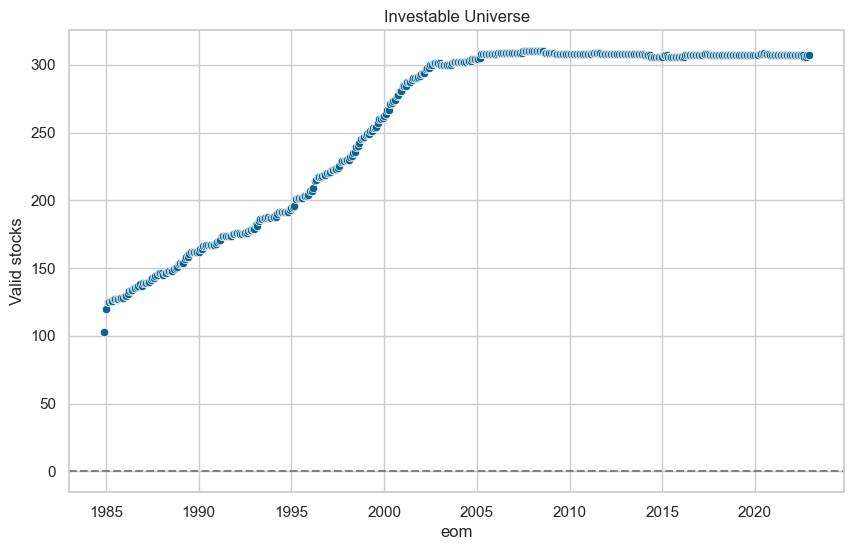

In [49]:
valid_counts = chars.loc[chars['valid'] == True].groupby('eom').size().reset_index(name='N')

# Plot investable universe
plt.figure(figsize=(10,6))
sns.scatterplot(data=valid_counts, x='eom', y='N')
plt.ylabel("Valid stocks")
plt.axhline(y=0, color='gray', linestyle='--')
plt.title("Investable Universe")
plt.show()

In [50]:
valid_pct = (chars['valid'].mean() * 100)
market_cap_valid = (chars.loc[chars['valid'] == True, 'me'].sum() / chars['me'].sum()) * 100
print(f"   The valid_data subset has {valid_pct:.2f}% of the observations and {market_cap_valid:.2f}% of the market cap")

   The valid_data subset has 93.39% of the observations and 99.38% of the market cap


In [51]:
chars.drop(columns="valid_int", inplace=True)
chars.shape

(125158, 130)

In [ ]:
output_path_chars_behandlet =  os.path.join(".", folder_name, "chars_behandlet.parquet")
chars.to_parquet(output_path_chars_behandlet, index=False)

## Daily

In [53]:
daily_file_path = os.path.join(".", folder_name, "usa_dsf_test.parquet")
output_path_daily = os.path.join(".", folder_name, "daily.csv")
daily = pd.read_parquet(daily_file_path, engine='pyarrow')
daily = daily[(daily['ret_exc'].notna()) &
              (daily['id'] <= 99999) &
              (daily['id'].isin(chars.loc[chars['valid'] == True, 'id'].unique()))]

# Tilføj en ny kolonne 'eom' med månedens sidste dag
daily['eom'] = daily['date'] + MonthEnd(0)
daily.to_csv(output_path_daily, index=False)

In [54]:
daily = pd.read_csv(output_path_daily, parse_dates=["date", "eom"])

In [55]:
output_path_usa = os.path.join(".", folder_name, "usa_test.parquet")
df_usa = pd.read_parquet(output_path_usa, engine='pyarrow')
kolonner = ["excntry", "id", "eom", "ret_exc_lead1m"]
monthly = df_usa[kolonner]

# Omdøb kolonnen 'ret_exc_lead1m' til 'ret_exc'
monthly = monthly.rename(columns={"ret_exc_lead1m": "ret_exc"})

# Filtrer kun USA og id <= 99999
monthly = monthly[(monthly["excntry"] == "USA") & (monthly["id"] <= 99999)]

# Konverter 'eom' til datoformat
monthly["eom"] = pd.to_datetime(monthly["eom"], format="%Y%m%d")

# Initialiser en tom liste til resultater
results = []

# Loop over horisonter i h_list
for h in h_list:
    # Beregn langsigtede afkast
    data_ret = long_horizon_ret(data=monthly, h=h, impute="zero")

    # Tilføj 'eom_ret'
    data_ret["eom_ret"] = data_ret["eom"] + pd.DateOffset(months=1) + MonthEnd(0)
    # Filtrer til relevante kolonner
    data_ret_ld1 = data_ret[["id", "eom", "eom_ret", f"ret_ld{h}"]]

    # Merge med risikofri data
    data_ret_ld1 = data_ret_ld1.merge(risk_free, on="eom", how="left")

    # Beregn total return
    data_ret_ld1["tr_ld1"] = data_ret_ld1[f"ret_ld{h}"] + data_ret_ld1["rf"]
    data_ret_ld1.drop(columns=["rf"], inplace=True)

    # Tilføj horisont som kolonne
    data_ret_ld1["horizon"] = h

    # Gem resultatet for denne horisont
    results.append(data_ret_ld1)

# Kombiner alle resultater til én samlet DataFrame
final_result = pd.concat(results, ignore_index=True)
file_monthly_preprocessed_test = os.path.join(".", folder_name, "monthly_preprocessed_test.csv")
final_result.to_csv(file_monthly_preprocessed_test, index=False)

final_result

All missing excludes 1.44% of the observations


,id,eom,eom_ret,ret_ld1,tr_ld1,horizon
0,10104,1986-12-31,1987-01-31,0.421617,0.426517,1
1,10104,1987-01-31,1987-02-28,0.137845,0.142045,1
2,10104,1987-02-28,1987-03-31,0.063897,0.068197,1
3,10104,1987-03-31,1987-04-30,0.155814,0.160514,1
4,10104,1987-04-30,1987-05-31,-0.188517,-0.184117,1
...,...,...,...,...,...,...
153572,92655,2023-06-30,2023-07-31,-0.063368,NaN,1
153573,92655,2023-07-31,2023-08-31,0.057611,NaN,1
153574,92655,2023-08-31,2023-09-30,0.057504,NaN,1
153575,92655,2023-09-30,2023-10-31,0.028084,NaN,1


# Gamle predictions uden demean

In [57]:
search_grid_single = pd.DataFrame({
    'name': ['m1'],
    'horizon': [1]
})
search_grid = search_grid_single

start_time = time.time()
models = []  # Liste til at gemme output for hver horizon

# Iterer over rækkerne i search_grid
for i in range(len(search_grid)):
    # Forbered y-variablen:
    h = search_grid.iloc[i]["horizon"]  # fx 1

    col_name = "ret_ld" + str(h)
    pred_y_values = chars[col_name]

    pred_y_df = chars[['id', 'eom']].copy()

    pred_y_df['eom_pred_last'] = pred_y_df['eom'] + MonthEnd(1)
    pred_y_df['ret_pred'] = pred_y_values

    valid_chars = chars[chars['valid'] == True]
    data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')

    update_freq = settings['split']['model_update_freq']
    if update_freq == "once":
        val_ends = [settings['split']['train_end']]
        test_inc = 1000
    elif update_freq == "yearly":
        # Opret en liste af datoer med årligt interval
        val_ends = pd.date_range(start=settings['split']['train_end'],
                                 end=settings['split']['test_end'],
                                 freq='YE').to_pydatetime().tolist()
        test_inc = 1
    elif update_freq == "decade":
        start_date = pd.to_datetime(settings['split']['train_end'])
        end_date = pd.to_datetime(settings['split']['test_end'])
        val_ends = []
        current = start_date
        while current <= end_date:
            val_ends.append(current)
            current += pd.DateOffset(years=10)
        test_inc = 10
    else:
        raise ValueError("Ugyldig model_update_freq i settings.")

    op = {}  # Dictionary til at gemme modeloutput for hver val_end
    inner_start = time.time()
    # Iterer over hver validerings-slutdato
    for val_end in val_ends:
        print(val_end)
        train_test_val = return_prediction_functions.data_split(
            data_pred,
            type=update_freq,
            val_end=val_end,
            val_years=settings['split']['val_years'],
            train_start=settings['screens']['start'],
            train_lookback=settings['split']['train_lookback'],
            retrain_lookback=settings['split']['retrain_lookback'],
            test_inc=test_inc,
            test_end=settings['split']['test_end']
        )
        print("datasættet er tomt; hvis ja, stop loopet")
        if train_test_val["test"].empty:
            print("Test datasættet er tomt for valideringsperiode:", val_end, ". Stopper forudsigelser.")
            break
        model_start = time.time()
        model_op = return_prediction_functions.rff_hp_search(
            train_test_val,
            feat=features,
            p_vec=settings['rff']['p_vec'],
            g_vec=settings['rff']['g_vec'],
            l_vec=settings['rff']['l_vec'],
            seed=settings['seed_no']
        )
        print("train_test_val", train_test_val)
        model_time = time.time() - model_start
        print("Model training time:", model_time, "seconds")
        op[val_end] = model_op
    inner_time = time.time() - inner_start
    print("Total time for current horizon:", inner_time, "seconds")

    # Gem model-output for den aktuelle horizon til en pickle-fil (svarer til R's saveRDS)
    model_filename = f"{output_path}/model_{h}.pkl"
    print("done med fil upload")
    with open(model_filename, "wb") as f:
        pickle.dump(op, f)

    models.append(op)

total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")


2000-12-31 00:00:00
datasættet er tomt; hvis ja, stop loopet
g: 0.049787068367863944
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 0.1353352832366127
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
Optimal g: 0.049787068367863944, p: 512.0, lambda: 12.494049928387, MSE: 0.010512457240698478
train_test_val {'val':            id        eom eom_pred_last  ret_pred  ncoa_gr1a   aliq_at  \
25      10104 1990-12-31    1991-01-31  0.138220   0.925000  0.944099   
26      10104 1991-01-31    1991-02-28 -0.004767   0.938650  0.950920   
27      10104 1991-02-28    1991-03-31 -0.004391   0.921687  0.939759   
28      10104 1991-03-31    1991-04-30  0.022443   0.831325  0.897590   
29      10104 1991-04-30    1991-05-31 -0.193650   0.851190  0.892857   
...       ...        ...           ...       ...        ...       ...   
116620  92655 2000-07-31    2000-08-31  0.150078 

# Demeaned

In [60]:
search_grid_single = pd.DataFrame({
    'name': ['m1'],
    'horizon': [1]
})
search_grid = search_grid_single

start_time = time.time()
models = []  # Liste til at gemme output for hver horizon

# Iterer over rækkerne i search_grid
for i in range(len(search_grid)):
    # Forbered y-variablen
    h = search_grid.iloc[i]["horizon"]  # fx 1
    col_name = "ret_ld" + str(h)
    pred_y_values = chars[col_name]

    # Lav en kopi med de nødvendige kolonner
    pred_y_df = chars[['id', 'eom']].copy()
    # Bevar eom_pred_last, som data_split skal bruge
    pred_y_df['eom_pred_last'] = pred_y_df['eom'] + MonthEnd(1)
    # Opret en kolonne til lookup: foregående måneds slutdato
    pred_y_df['eom_prev'] = pred_y_df['eom'] - MonthEnd(1)
    # Tilsæt afkastværdierne
    pred_y_df['ret_pred'] = pred_y_values

    valid_chars = chars[chars['valid'] == True]
    data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')

    # ----------------- DE-MEAN: Træk den foregående måneds gennemsnit fra -----------------
    # Udregn månedligt gennemsnit baseret på den foregående måneds dato (eom_prev)
    data_pred['mean_ret'] = data_pred.groupby('eom_prev')['ret_pred'].transform('mean')
    print("NaN i mean_ret kolonnen:")
    print(data_pred['mean_ret'][data_pred['mean_ret'].isna()])

    # Beregn de-meanede afkast
    data_pred['ret_pred_demeaned'] = data_pred['ret_pred'] - data_pred['mean_ret']
    # Sørg for, at modellen trænes på de-meanede værdier
    data_pred['ret_pred'] = data_pred['ret_pred_demeaned']
    # -----------------------------------------------------------------------------------------

    update_freq = settings['split']['model_update_freq']
    if update_freq == "once":
        val_ends = [settings['split']['train_end']]
        test_inc = 1000
    elif update_freq == "yearly":
        # Opret en liste af datoer med årligt interval
        val_ends = pd.date_range(start=settings['split']['train_end'],
                                 end=settings['split']['test_end'],
                                 freq='YE').to_pydatetime().tolist()
        test_inc = 1
    elif update_freq == "decade":
        start_date = pd.to_datetime(settings['split']['train_end'])
        end_date = pd.to_datetime(settings['split']['test_end'])
        val_ends = []
        current = start_date
        while current <= end_date:
            val_ends.append(current)
            current += pd.DateOffset(years=10)
        test_inc = 10
    else:
        raise ValueError("Ugyldig model_update_freq i settings.")

    op = {}  # Dictionary til at gemme modeloutput for hver validerings-slutdato
    inner_start = time.time()
    # Iterer over hver validerings-slutdato
    for val_end in val_ends:
        print(val_end)
        train_test_val = return_prediction_functions.data_split(
            data_pred,
            type=update_freq,
            val_end=val_end,
            val_years=settings['split']['val_years'],
            train_start=settings['screens']['start'],
            train_lookback=settings['split']['train_lookback'],
            retrain_lookback=settings['split']['retrain_lookback'],
            test_inc=test_inc,
            test_end=settings['split']['test_end']
        )
        print("datasættet er tomt; hvis ja, stop loopet")
        if train_test_val["test"].empty:
            print("Test datasættet er tomt for valideringsperiode:", val_end, ". Stopper forudsigelser.")
            break
        model_start = time.time()
        model_op = return_prediction_functions.rff_hp_search(
            train_test_val,
            feat=features,
            p_vec=settings['rff']['p_vec'],
            g_vec=settings['rff']['g_vec'],
            l_vec=settings['rff']['l_vec'],
            seed=settings['seed_no']
        )
        print("train_test_val", train_test_val)
        model_time = time.time() - model_start
        print("Model training time:", model_time, "seconds")
        op[val_end] = model_op
    inner_time = time.time() - inner_start
    print("Total time for current horizon:", inner_time, "seconds")

    # ----------------- Gen-add: Læg den foregående måneds gennemsnit til forudsigelserne -----------------
    # Opret DataFrame med månedlige gennemsnit baseret på eom_prev
    monthly_means_df = (data_pred[['eom_prev', 'mean_ret']]
                         .drop_duplicates()
                         .sort_values('eom_prev')
                         .reset_index(drop=True))
    
    # For hver valideringsdato, merge monthly_means_df med forudsigelses-DataFrame'en
    for key in list(op.keys()):
        if isinstance(key, datetime.datetime):
            model_dict = op[key]
            if 'pred' in model_dict:
                pred_df = model_dict['pred']
                # Hvis pred_df ikke har 'eom_prev', kan vi genberegne den herfra ud fra 'eom'
                if 'eom_prev' not in pred_df.columns:
                    pred_df['eom_prev'] = pred_df['eom'] - MonthEnd(1)
                # Merge på eom_prev
                pred_df = pred_df.merge(monthly_means_df, on='eom_prev', how='left')
                print("pred_df før tilføjelse af monthly mean:", pred_df.head())
                # Genskab de oprindelige afkast ved at lægge mean_ret til de de-meanede forudsigelser
                pred_df['pred'] = pred_df['pred'] + pred_df['mean_ret']
                print("pred_df efter tilføjelse af monthly mean:", pred_df.head())
                model_dict['pred'] = pred_df
                op[key] = model_dict
    # ---------------------------------------------------------------------------------------------
model_filename = f"{output_path}/demeaned_model_{1}.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(op, f)

models.append(op)

total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")


NaN i mean_ret kolonnen:
Series([], Name: mean_ret, dtype: float64)
2000-12-31 00:00:00
datasættet er tomt; hvis ja, stop loopet
g: 0.049787068367863944
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 0.1353352832366127
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
Optimal g: 0.049787068367863944, p: 512.0, lambda: 8.341241958842371, MSE: 0.008833511381234047
train_test_val {'val':            id        eom eom_pred_last   eom_prev  ret_pred  ncoa_gr1a  \
25      10104 1990-12-31    1991-01-31 1990-11-30  0.069124   0.925000   
26      10104 1991-01-31    1991-02-28 1990-12-31 -0.090228   0.938650   
27      10104 1991-02-28    1991-03-31 1991-01-31 -0.043093   0.921687   
28      10104 1991-03-31    1991-04-30 1991-02-28  0.022414   0.831325   
29      10104 1991-04-30    1991-05-31 1991-03-31 -0.241620   0.851190   
...       ...        ...           ...        

Sikkerhedstjek:

In [ ]:

pred_list = []

for date, subdict in op.items():
    # Hent 'pred' DataFrame fra den aktuelle dictionary
    pred_df = subdict['pred'].copy()
    

    # Tilføj DataFrame'et til listen
    pred_list.append(pred_df)

# Saml alle DataFrames til ét samlet DataFrame
all_preds_df = pd.concat(pred_list, ignore_index=True)

# Udskriv de første par rækker
print(all_preds_df.head())
print(all_preds_df.shape)
print(chars.shape)

In [ ]:
file_path = os.path.join(output_path, f"model_{h}.pkl")
with open(file_path, 'rb') as f:
    op_new = pickle.load(f)
    
# Ekstraher alle 'pred'-dataframes i en liste
pred_list_new = []

# Gå igennem alle nøgler (valideringsdatoer) i dictionary'en
for val_end, subdict in op_new.items():
    if 'pred' in subdict:
        pred_df = subdict['pred'].copy()
        
        # Merge pred_df med monthly_means_df på eom_pred_last (fra pred_df) og eom (fra monthly_means_df)
        pred_df = pred_df.merge(monthly_means_df, left_on='eom_pred_last', right_on='eom', how='left')
        # Fjern evt. ekstra eom-kolonner og standardiser navnet
        pred_df = pred_df.drop(columns=['eom_x']).rename(columns={'eom_y': 'eom'})
        
        # Debug: Find rækker hvor mean_ret er NaN (altså hvor merge ikke fandt et match)
        missing_means = pred_df[pred_df['mean_ret'].isna()]
        if not missing_means.empty:
            print(f"Observationer med manglende monthly_mean for valideringsdato {val_end}:")
            # Udskriv nogle relevante kolonner, f.eks. id, eom_pred_last, pred
            print(missing_means[['id', 'eom_pred_last', 'pred']])
            print("Antal manglende:", missing_means.shape[0])
        
        # Re-add de-meanede afkast: Tilføj mean_ret til pred for at genskabe de oprindelige afkast
        # (Bemærk: Hvis mean_ret er NaN, bliver den nye pred NaN)
        pred_df['pred'] = pred_df['pred'] + pred_df['mean_ret']
        
        # Opdater dictionary'en for denne valideringsdato
        subdict['pred'] = pred_df
        
        # Tilføj den opdaterede pred_df til listen
        pred_list_new.append(pred_df)

# Sammensæt alle pred_df'er til én samlet DataFrame
all_preds_new_df = pd.concat(pred_list_new, ignore_index=True)

# Udskriv nogle stikprøver
print("Første par rækker for new:")
print(all_preds_new_df.head())
print("Samlet shape for new:", all_preds_new_df.shape)

# Beregn og udskriv antallet af NaNs i 'pred'
nan_count_new = all_preds_new_df['pred'].isna().sum()
print("Antal NaNs i 'pred' for new:", nan_count_new)

In [ ]:
file_path = os.path.join(output_path, f"demeaned_model_{h}.pkl")
with open(file_path, 'rb') as f:
    op_new = pickle.load(f)
    
# Ekstraher alle 'pred'-dataframes i en liste
pred_list_new = []

# Gå igennem alle nøgler (valideringsdatoer) i dictionary'en
for val_end, subdict in op_new.items():
    if 'pred' in subdict:
        pred_df = subdict['pred'].copy()
        
        # Merge pred_df med monthly_means_df på eom_pred_last (fra pred_df) og eom (fra monthly_means_df)
        pred_df = pred_df.merge(monthly_means_df, left_on='eom_pred_last', right_on='eom', how='left')
        # Fjern evt. ekstra eom-kolonner og standardiser navnet
        pred_df = pred_df.drop(columns=['eom_x']).rename(columns={'eom_y': 'eom'})
        
        # Debug: Find rækker hvor mean_ret er NaN (altså hvor merge ikke fandt et match)
        missing_means = pred_df[pred_df['mean_ret'].isna()]
        if not missing_means.empty:
            print(f"Observationer med manglende monthly_mean for valideringsdato {val_end}:")
            # Udskriv nogle relevante kolonner, f.eks. id, eom_pred_last, pred
            print(missing_means[['id', 'eom_pred_last', 'pred']])
            print("Antal manglende:", missing_means.shape[0])
        
        # Re-add de-meanede afkast: Tilføj mean_ret til pred for at genskabe de oprindelige afkast
        # (Bemærk: Hvis mean_ret er NaN, bliver den nye pred NaN)
        pred_df['pred'] = pred_df['pred'] + pred_df['mean_ret']
        
        # Opdater dictionary'en for denne valideringsdato
        subdict['pred'] = pred_df
        
        # Tilføj den opdaterede pred_df til listen
        pred_list_new.append(pred_df)

# Sammensæt alle pred_df'er til én samlet DataFrame
all_preds_new_df = pd.concat(pred_list_new, ignore_index=True)

# Udskriv nogle stikprøver
print("Første par rækker for new:")
print(all_preds_new_df.head())
print("Samlet shape for new:", all_preds_new_df.shape)

# Beregn og udskriv antallet af NaNs i 'pred'
nan_count_new = all_preds_new_df['pred'].isna().sum()
print("Antal NaNs i 'pred' for new:", nan_count_new)